# IRB credit risk insights from the EBA's 2021 EU-wide stress test

The aim of this notebook is to create heuristics for assessing the loss multiplier under stress conditions for different regulatory exposure classes. The underlying assumption is that the expected loss under normal conditions is not so difficult to forecast. If we could establish how the losses typically behave during stress scenario in comparison to average economic conditions, we will have an additional tool to validate our credit risk models.

This notebook provides a starting point and is not a final solution. There are many ways to enhance these calculations:
- introduce bins based on initial riskiness of the portfolio as in terms of a loss multiplier is higher for better credit risk bands
- introducing geographical dimension 
- removing some obvious (and not so obvious) outliers
- excluding banks that are different from yours
- extended this analysis to multiple periods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from datetime import datetime

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pd.options.display.float_format = '{:,.1%}'.format

### A. Import the dataset
Import previously prepared data (see notebook 'data preparation.ipynb'). Original data dictionary and metadata can be obtained from https://www.eba.europa.eu/risk-analysis-and-data/eu-wide-stress-testing/2021.

In [2]:
# Import data
credit_risk = pd.read_excel('output_data/2021_stress_test_irb.xlsx')

### B. Overview of the dataset

This dataset includes five items:
- IRB - Exposures  by IFRS9 Stages
- IRB - Stock of Provisions  by IFRS9 Stages
- IRB - Coverage ratios
- IRB - Exposure values - by status (Defaulted and Non defaulted) and by Portfolio (AIRB and FIRB)
- IRB - Risk Exposures amounts - by status (Defaulted and Non defaulted) and by Portfolio (AIRB and FIRB)

Although on the first glance the number of items may seem small, one can benchmark RWA cyclicality and estimated losses for different scenarios for CRR Exposure Classes and different countries.

Regulatory Exposure Classes covered in this dataset (for several classes, unfortunately the number of banks is limited).
- Central banks
- Central governments
- Retail - Other - Non SME
- Retail - Other - SME
- Retail - Other
- Retail  - Qualifying Revolving
- Retail - Secured by real estate property - Non SME
- Retail - Secured by real estate property - SME
- Retail - Secured by real estate property
- Retail
- Corporates - SME
- Corporates - Specialised Lending
- Corporates (Credit Risk) / Non Financial corporations (NPE- Forbearance)
- Institutions
- Equity
- Other non-credit obligation assets

In [3]:
# Cleansing
col = 'Corporates (Credit Risk) / Non Financial corporations (NPE- Forbearance)'
credit_risk = credit_risk.replace({'exposure_description': 
                                       {col: 'Corporates', 
                                       'TOTAL': 'All exposure classes'}})

### C. Analyse losses 

In [4]:
# Drop country-specific information and non-loss related fields
idx1 = credit_risk['item_label'].isin(['IRB - Stock of Provisions by IFRS9 Stages', 
                                       'IRB - Exposures by IFRS9 Stages'])
idx2 = credit_risk['country_name'].isin(['Total / No breakdown'])
losses = credit_risk[idx1 & idx2]

In [5]:
# Add starting data to 'Adverse scenario' and 'Baseline scenario'
starting_point = losses[losses['scenario_description'].isin(['Actual figures'])]

sp1 = starting_point.copy()
sp1['scenario_description'] = 'Adverse scenario'
sp2 = starting_point.copy()
sp2['scenario_description'] = 'Baseline scenario'

# Concatenate all dataframes
losses = pd.concat([losses, sp1, sp2], ignore_index=True)

# Create more informative label for periods
losses['period']=pd.to_datetime(losses['period'])
losses['period_label'] = losses['period'].dt.strftime('year_%y')

In [6]:
# Pivot for stress test scenario and regulatory exposure class
df1 = losses.pivot_table(
                index=['bank_name', 
                       'scenario_description', 
                       'exposure_description'], 
                columns=['period_label', 
                         'item_label'], 
                values='amount'
                        ).reset_index()

df1 = df1[df1['scenario_description']!='Actual figures']
df1.columns = [ 
               'bank_name', 
               'scenario_description', 
               'exposure_description',
               'exposure_20',
               'provisions_20', 
               'exposure_21',  
               'provisions_21', 
               'exposure_22', 
               'provisions_22', 
               'exposure_23',
               'provisions_23' 
               ]

# Create variables for loss calculation
df1['1_year_change'] = df1['provisions_21'] - df1['provisions_20']
df1['2_year_change'] = df1['provisions_22'] - df1['provisions_20']
df1['3_year_change'] = df1['provisions_23'] - df1['provisions_20']

df1['1_year_cum_change'] = df1['provisions_21'] - df1['provisions_20']
df1['2_year_cum_change'] = df1['provisions_22'] - df1['provisions_21']
df1['3_year_cum_change'] = df1['provisions_23'] - df1['provisions_22']

df1['1_year_cum_perc_change'] = df1['1_year_cum_change'] / df1['exposure_20']
df1['2_year_cum_perc_change'] = df1['2_year_cum_change'] / df1['exposure_20']
df1['3_year_cum_perc_change'] = df1['3_year_cum_change'] / df1['exposure_20']

In [7]:
# Remove cases where there was no loss (not always a data quality problem)
idx = df1['1_year_change']>0.001
print(f'{sum(-idx) / len(df1):,.2%} of records have inconsistencies and were removed')

df1 = df1[idx]

14.57% of records have inconsistencies and were removed


In [8]:
# Per bank 1-year loss baseline vs adverse scenario
df2 = df1.pivot_table(
                    index=['bank_name', 'exposure_description'], 
                    columns=['scenario_description'], 
                    values='1_year_cum_perc_change'
                            ).reset_index()


df2['adverse_vs_baseline'] = df2['Adverse scenario'] / df2['Baseline scenario']
df2 = df2.sort_values(by=['exposure_description', 'adverse_vs_baseline'], ascending=False)

### D. Create heuristics

In [9]:
# Create quantiles of the loss ratio
df3 = df2.groupby('exposure_description').agg({'adverse_vs_baseline': [
               lambda x: x.quantile(0.25), 
               lambda x: x.quantile(0.5),
               lambda x: x.quantile(0.75)]}).reset_index()

df3.columns = ['Exposure Class', '25th perc', '50th perc', '75th perc']

In [10]:
# Show the result
df3

,Exposure Class,25th perc,50th perc,75th perc
0,All exposure classes,289.9%,372.0%,562.2%
1,Central banks,106.2%,144.7%,176.5%
2,Central governments,105.7%,166.3%,221.6%
3,Corporates,307.8%,406.7%,680.1%
4,Corporates - SME,254.8%,355.8%,582.2%
5,Corporates - Specialised Lending,172.6%,338.8%,500.1%
6,Equity,277.6%,408.0%,498.1%
7,Institutions,211.1%,310.0%,604.5%
8,Other non-credit obligation assets,151.5%,240.4%,434.9%
9,Retail,220.5%,356.8%,486.7%


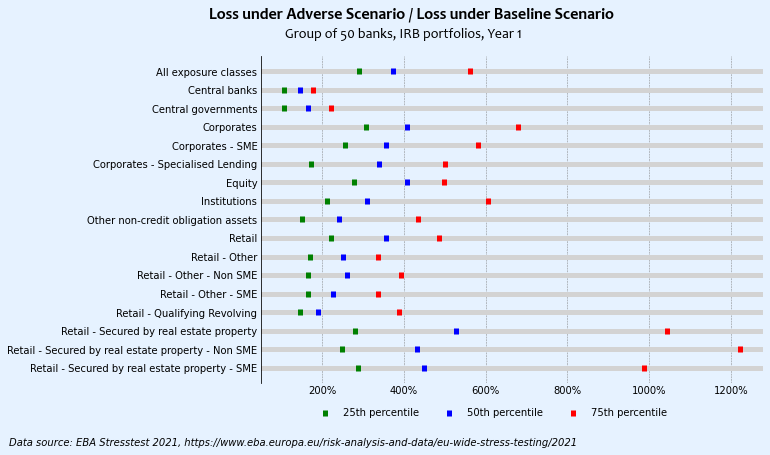

In [11]:
# Create graph
color = '#e6f2ff'

# Create plot
df3 = df3.sort_values(by='Exposure Class', ascending=False)
fig = plt.figure(figsize=(9, 6), facecolor='darkgrey')
ax1 = fig.add_subplot(111)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

def scatter_fun(df, var, label, color):
    return ax1.scatter(df[var], 
                       df['Exposure Class'], 
                       linewidths=5, 
                       alpha=1., 
                       c=color, 
                       marker="|", 
                       label=label)

scatter_fun(df3, '25th perc', '25th percentile', 'g')
scatter_fun(df3, '50th perc', '50th percentile', 'b')
scatter_fun(df3, '75th perc', '75th percentile', 'r')

ax1.yaxis.grid(True, color='lightgray', linewidth=5)
ax1.xaxis.grid(True, color='gray', linestyle='dashed', linewidth=0.5)
ax1.legend(loc=[0.1, -0.12], facecolor=color, edgecolor=color, ncol=3)
ax1.set_axisbelow(True)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='both', which='both', length=0)

fig.patch.set_facecolor(color)
ax1.set_facecolor(color=color)
ax1.set_axisbelow(True)

plt.title('Loss under Adverse Scenario / Loss under Baseline Scenario', 
          fontsize=16, 
          x=0.3, 
          y=1.1, 
          fontname='Candara', 
          fontweight='bold')

ax1.text(0.52, 1.05, 
         'Group of 50 banks, IRB portfolios, Year 1',
         verticalalignment='bottom', 
         horizontalalignment='right',
         transform=ax1.transAxes,
         color='black', 
         fontname='Candara', 
         # style='italic',
         fontsize=14)

ax1.text(0.63, -0.2, 
         'Data source: EBA Stresstest 2021, ' \
         'https://www.eba.europa.eu/risk-analysis-and-data/' \
         'eu-wide-stress-testing/2021',
         verticalalignment='bottom', 
         horizontalalignment='right',
         transform=ax1.transAxes,
         color='black', 
         style='italic',
         fontsize=10)

plt.savefig('output_data/loss_per_exp_class.pdf', bbox_inches = 'tight')

### Appendix. Value counts of dimensions

In [12]:
credit_risk['portfolio_description'].value_counts(dropna=False)

IRB      458150
A-IRB     37400
F-IRB     33000
Name: portfolio_description, dtype: int64

In [13]:
credit_risk['item_label'].value_counts(dropna=False)

IRB - Exposures by IFRS9 Stages                                                                            196350
IRB - Stock of Provisions by IFRS9 Stages                                                                  196350
IRB - Coverage ratios                                                                                       65450
IRB - Exposure values - by status (Defaulted and Non defaulted) and by Portfolio (AIRB and FIRB)            35200
IRB - Risk Exposures amounts - by status (Defaulted and Non defaulted) and by Portfolio (AIRB and FIRB)     35200
Name: item_label, dtype: int64

In [14]:
credit_risk['exposure_description'].value_counts(dropna=False)

Central banks                                         31350
Central governments                                   31350
Retail - Other - Non SME                              31350
Retail - Other - SME                                  31350
Retail - Other                                        31350
Retail - Qualifying Revolving                         31350
Retail - Secured by real estate property - Non SME    31350
Retail - Secured by real estate property - SME        31350
Retail - Secured by real estate property              31350
Retail                                                31350
Corporates - SME                                      31350
Corporates - Specialised Lending                      31350
Corporates                                            31350
Institutions                                          31350
All exposure classes                                  31350
Equity                                                29150
Other non-credit obligation assets      

In [15]:
credit_risk['ifrs9_stages_description'].value_counts(dropna=False)

Stage 3                         196350
Stage 1                         130900
Stage 2                         130900
No breakdown by IFRS9_Stages     70400
Name: ifrs9_stages_description, dtype: int64

In [16]:
credit_risk['status_description'].value_counts(dropna=False)

No breakdown by status    458150
Non defaulted assets       35200
Defaulted assets           35200
Name: status_description, dtype: int64

In [17]:
credit_risk['scenario_description'].value_counts(dropna=False)

Baseline scenario    196350
Adverse scenario     196350
Actual figures       135850
Name: scenario_description, dtype: int64